# Group Assignment 2

##### Nevin Baiju
##### Bondili Ram Vishal Singh


## Library imports

In [ ]:
import os, shutil, pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt
import numpy as np

## Data exploration

## Methodology

In this experiment, we will be using a bigger dataset with similar characteristics to build a good model and then use that model as a feature extractor to train an ANN to predict our classes.

Since our problem statement corresponds to dogs, we have decided to select the dogs vs cats dataset which is large enough to train a CNN with good generalization and that will serve as a good feature extractor as it is able to extract the features of a dog. 

### Building the cats vs dogs model

We are using the VGG-16 model to build the model that classifies if its a cat or a dog.

####  Dowloading the data from Kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

In [ ]:
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

#### Preparing the data

Moving them into different folders for train, test, validation for different classes

In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=9000)
make_subset("validation", start_index=9000, end_index=10000)
make_subset("test", start_index=10000, end_index=12500)

Loading the dataset using the image_dataset_from_directory

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

#### Building the model

Defining data augmentations

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

##### Defining the network

Using the VGG-16 from keras

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

Defining the final model with the ANN layers

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Freezing all layers except the last 4 convolutional layers for training

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Training the model

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="dogs_vs_cats.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Testing the model

In [ ]:
model = keras.models.load_model("dogs_vs_cats.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
files.download('dogs_vs_cats.keras')

### Building the labrador vs doberman model

In [ ]:
test_dataset = image_dataset_from_directory(
    "test_data/",
    image_size=(180, 180),
    seed=42,
    batch_size=32)
train_dataset, validation_dataset = image_dataset_from_directory(
    "custom_dataset/",
    image_size=(180, 180),
    subset='both',
    seed=42,
    validation_split=0.2,
    batch_size=32)

Found 100 files belonging to 2 classes.
Found 388 files belonging to 2 classes.
Using 311 files for training.
Using 77 files for validation.


Loading the cats vs dogs model we created earlier

In [ ]:
model = keras.models.load_model('cats_vs_dogs_vgg.keras')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                             

Using only the convolutional layers from that model

In [ ]:
# Selecting only the convolutional layers of our earlier model for extracting the features
feature_extractor = keras.Model(model.inputs, model.layers[-3].output)
feature_extractor.trainable = False

Extracting the features from the 

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        features = feature_extractor.predict(images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 1s 968ms/step


Defining the ANN layers

In [ ]:
inputs = keras.Input(shape=(256))
x = layers.Flatten()(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="lab_vs_dob.keras",
      save_best_only=True)
]
history = model.fit(
    train_features, train_labels,
    epochs=100,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)



Epoch 1/100
10/10 [==============================] - 1s 24ms/step - loss: 5.8600 - accuracy: 0.5852 - val_loss: 1.8670 - val_accuracy: 0.7662
Epoch 2/100
10/10 [==============================] - 0s 8ms/step - loss: 3.8911 - accuracy: 0.6720 - val_loss: 1.3485 - val_accuracy: 0.8312
Epoch 3/100
10/10 [==============================] - 0s 9ms/step - loss: 3.5561 - accuracy: 0.7106 - val_loss: 0.9784 - val_accuracy: 0.8571
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 3.6381 - accuracy: 0.7170 - val_loss: 0.7183 - val_accuracy: 0.8831
Epoch 5/100
10/10 [==============================] - 0s 11ms/step - loss: 2.6559 - accuracy: 0.7814 - val_loss: 0.5868 - val_accuracy: 0.8961
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 2.2018 - accuracy: 0.7910 - val_loss: 0.4557 - val_accuracy: 0.9091
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 1.5280 - accuracy: 0.7974 - val_loss: 0.5822 - val_accuracy: 0.8961
Epoch 8/10

10/10 [==============================] - 0s 9ms/step - loss: 0.4856 - accuracy: 0.9518 - val_loss: 0.0147 - val_accuracy: 0.9870
Epoch 59/100
10/10 [==============================] - 0s 6ms/step - loss: 0.1304 - accuracy: 0.9678 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 60/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1697 - accuracy: 0.9582 - val_loss: 0.0152 - val_accuracy: 0.9870
Epoch 61/100
10/10 [==============================] - 0s 6ms/step - loss: 0.2728 - accuracy: 0.9518 - val_loss: 0.0240 - val_accuracy: 0.9870
Epoch 62/100
10/10 [==============================] - 0s 7ms/step - loss: 0.2935 - accuracy: 0.9453 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 63/100
10/10 [==============================] - 0s 7ms/step - loss: 0.2597 - accuracy: 0.9614 - val_loss: 0.0123 - val_accuracy: 0.9870
Epoch 64/100
10/10 [==============================] - 0s 6ms/step - loss: 0.2458 - accuracy: 0.9550 - val_loss: 0.0176 - val_accuracy: 0.9870
Epoch 65/100
10/10 

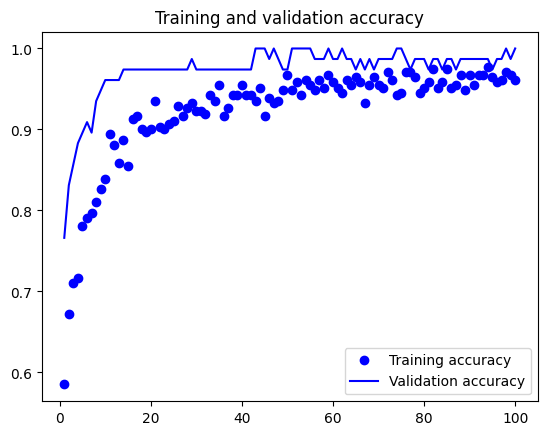

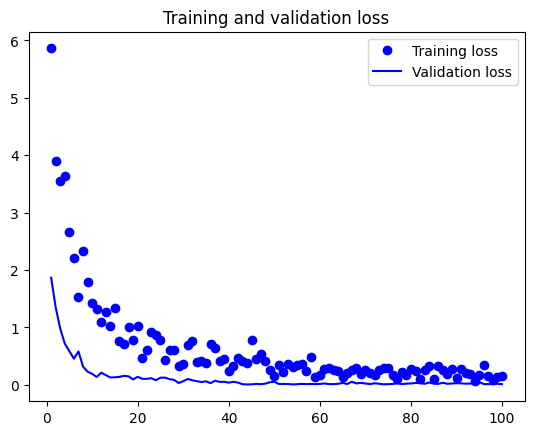

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# model = keras.models.load_model("dogs_vs_cats.keras")
test_loss, test_acc = model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

4/4 [==============================] - 0s 3ms/step - loss: 0.0664 - accuracy: 0.9900
Test accuracy: 0.990


In [ ]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256)]             0         
                                                                 
 flatten_9 (Flatten)         (None, 256)               0         
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


### Conclusion

To conclude, we can see that the model we have built is fairly robust and performs well on the validation and the testing data. With more training data, we can make the model a lot more robust to distinguish these two dogs in the real world. And we need not train the model for such a high number of epochs.